In [1]:
import pandas as pd
import numpy as np
import random
import xgboost as xgb
from xgboost import plot_importance 
from toad.metrics import KS,AUC
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from imbalanced_ensemble.ensemble import SelfPacedEnsembleClassifier
from sklearn.metrics import roc_curve

In [2]:
def calAUC(y_pred,y_true):
    y_true = list(y_true)
    f = list(zip(y_pred,y_true))
    rank = [values2 for values1,values2 in sorted(f,key=lambda x:x[0])]
    rankList = [i+1 for i in range(len(rank)) if rank[i]==1]
    posNum = 0
    negNum = 0
    for i in range(len(y_true)):
        if(y_true[i]==1):
            posNum+=1
        else:
            negNum+=1
    auc = 0
    auc = (sum(rankList)- (posNum*(posNum+1))/2)/(posNum*negNum)
    print(auc)
    return auc

In [3]:
data=pd.read_csv("credit.csv")
x = data.drop(['default'],axis=1)
y = data.default
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [8]:
params = {'n_estimators':1000,
         'max_depth':4,
         'subsample':0.7,
         'learning_rate':0.05}

In [13]:
model = xgb.XGBClassifier(n_estimators = 1000,max_depth=4,verbosity=1,subsample = 0.7,learning_rate=0.05,random_state=42)

[0]	validation_0-auc:0.75261	validation_1-auc:0.74137
[200]	validation_0-auc:0.83507	validation_1-auc:0.77914
[343]	validation_0-auc:0.86091	validation_1-auc:0.77588
AUC: 0.779729 
KS: 0.433298 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

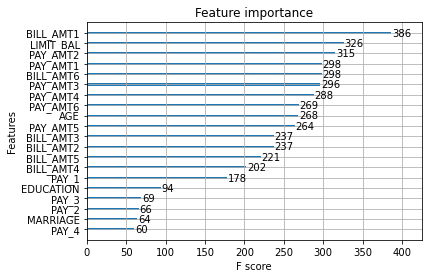

In [14]:
model.fit(x_train,y_train,eval_metric=['auc'],verbose=200,eval_set = [( x_train,y_train),(x_test,y_test)],early_stopping_rounds=200)
pred = model.predict_proba(x_test)
print('AUC: {:.6f} '.format(AUC(pred[:,1],y_test)))
print('KS: {:.6f} '.format(KS(pred[:,1],y_test)))
plot_importance(model,max_num_features=20)

In [15]:
clf = SelfPacedEnsembleClassifier(
        base_estimator = model,
        verbose=True,
        k_bins=5,
    #基准分类模型 可以自定义，需要模型包含fit等方法
        n_estimators = 40,
        random_state=49,
    ).fit(x_train, y_train,
          balancing_schedule='progressive',
          eval_datasets  = {'valid': (x_test, y_test)},
          train_verbose= {
            'granularity': 1,
            'print_distribution': True,
            'print_metrics': True}
         )

[17:59:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             ┃                     ┃            Data: train             ┃            Data: valid             ┃
┃ #Estimators ┃ Class Distribution  ┃               Metric               ┃               Metric               ┃
┃             ┃                     ┃  acc    balanced_acc   weighted_f1 ┃  acc    balanced_acc   weighted_f1 ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃      1      ┃ {0: 14071, 1: 3929} ┃ 0.866      0.731          0.853    ┃ 0.813      0.661          0.793    ┃
[18:00:00] WARNING

┃     19      ┃ {0: 9391, 1: 3929}  ┃ 0.872      0.742          0.859    ┃ 0.815      0.663          0.795    ┃
[18:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┃     20      ┃ {0: 9131, 1: 3929}  ┃ 0.872      0.743          0.860    ┃ 0.814      0.662          0.794    ┃
[18:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┃     21      ┃ {0: 8870, 1: 3929}  ┃ 0.873      0.743          0.860    ┃ 0.815      0.663          0.795    ┃
[18:01:44] WARNING: C:/Users/Administrator/w

┃     39      ┃ {0: 4190, 1: 3929}  ┃ 0.883      0.769          0.874    ┃ 0.815      0.672          0.798    ┃
[18:03:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
┃     40      ┃ {0: 3929, 1: 3929}  ┃ 0.884      0.771          0.875    ┃ 0.814      0.672          0.797    ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃    final    ┃ {0: 3929, 1: 3929}  ┃ 0.884      0.771          0.875    ┃ 0.814      0.672          0.797    ┃
┗━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [16]:
pred =clf.predict_proba(x_test)
print('AUC: {:.6f} '.format(AUC(pred[:,1],y_test)))
print('KS: {:.6f} '.format(KS(pred[:,1],y_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


AUC: 0.769621 
KS: 0.424057 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [17]:
gg=pd.read_csv('sampled_data.csv')
gg.columns = data.columns
Y_train = gg.pop('default')
X_train = gg

[0]	validation_0-auc:0.74886	validation_1-auc:0.74423
[200]	validation_0-auc:0.83466	validation_1-auc:0.78036
[380]	validation_0-auc:0.86702	validation_1-auc:0.77737
AUC: 0.780935 
KS: 0.437793 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

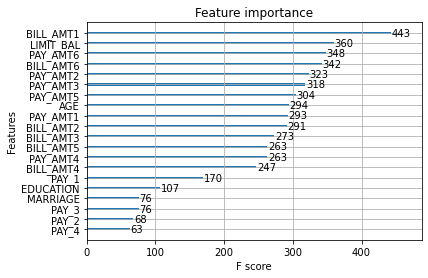

In [18]:
model.fit(X_train,Y_train,eval_metric=['auc'],verbose=200,eval_set = [( X_train,Y_train),(x_test,y_test)],early_stopping_rounds=200)
pred = model.predict_proba(x_test)
print('AUC: {:.6f} '.format(AUC(pred[:,1],y_test)))
print('KS: {:.6f} '.format(KS(pred[:,1],y_test)))
plot_importance(model,max_num_features=20)

In [24]:
ensembles = {}
ensembles['spe'] = clf

Visualizer evaluating model spe on dataset train :: 100%|██████████████████████████████| 40/40 [00:05<00:00,  7.44it/s]
Visualizer evaluating model spe on dataset valid :: 100%|██████████████████████████████| 40/40 [00:02<00:00, 17.68it/s]


Visualizer computing confusion matrices.. Finished!


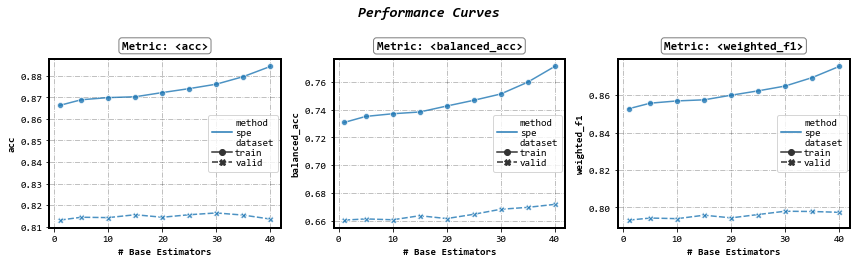

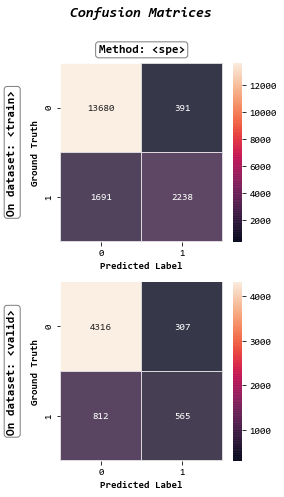

In [26]:
from imbalanced_ensemble.visualizer import ImbalancedEnsembleVisualizer

visualizer = ImbalancedEnsembleVisualizer(
        eval_datasets = None,
        eval_metrics = None,
    ).fit(
        ensembles = ensembles,
        granularity = 5,
    )
fig, axes = visualizer.performance_lineplot(
        on_ensembles=None,
        on_datasets=None,
        split_by=[],
        n_samples_as_x_axis=False,
        sub_figsize=(4, 3.3),
        sup_title=True,
        alpha=0.8,
    )
fig, axes = visualizer.confusion_matrix_heatmap(
        on_ensembles=None,
        on_datasets=None,
        sub_figsize=(4, 3.3),
    )
